## Lab 9:  Logistic Regression
#### CS 3841
#### Draven Schilling
#### 11/13/19

An estimated 268,000 women and 2,670 men in the United States are diagnosed with breast cancer every year. Of which, an estimated 42,260 deaths a year are contributed to best cancer making breast cancer one of the leading forms of cancer.

Breast cancer is a form of cancer that begins in the breast and is prompted to start when cancerous cells begin to grow out of control. Breast cancer cells usually form a tumor that can often be seen on an x-ray or felt as a lump in the breast. Usually it occurs almost entirely in women, but in rare cases men can get breast cancer too. It’s important to understand that most breast lumps are benign and not cancerous (malignant). Non-cancerous breast tumors are abnormal growths, but they do not spread outside of the breast. They are not life threatening, but some types of benign breast lumps can increase a woman's risk of getting breast cancer in the future. 

In this notebook we will be looking at a data set containing features computed from a digitalized image of "fine needle aspirate" (FNA) for breast masses. The "features" in the data set summarize characteristics of the cell nuclei present in the image. We will attempt to identify any features which correlate strongly with the accepted diagnosis (benign / malignant) then create a classification model which predicts the diagnosis using those features which correlate strongly.

The data set contains a unique ID column, Diagnosis column (benign / malignant), and 30 feature columns.

Let’s start by loading in the data and getting a preview.

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import seaborn as sns

from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [2]:
Columns = ['ID', 'Diagnosis']
for i in range(1,31):
    Columns.append('Feature'+str(i))
cancer_df = pd.read_csv('wdbc.data', names=Columns, header=None)
cancer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
ID           569 non-null int64
Diagnosis    569 non-null object
Feature1     569 non-null float64
Feature2     569 non-null float64
Feature3     569 non-null float64
Feature4     569 non-null float64
Feature5     569 non-null float64
Feature6     569 non-null float64
Feature7     569 non-null float64
Feature8     569 non-null float64
Feature9     569 non-null float64
Feature10    569 non-null float64
Feature11    569 non-null float64
Feature12    569 non-null float64
Feature13    569 non-null float64
Feature14    569 non-null float64
Feature15    569 non-null float64
Feature16    569 non-null float64
Feature17    569 non-null float64
Feature18    569 non-null float64
Feature19    569 non-null float64
Feature20    569 non-null float64
Feature21    569 non-null float64
Feature22    569 non-null float64
Feature23    569 non-null float64
Feature24    569 non-null float64
Feature25    5

In [3]:
cancer_df.head()

ID Diagnosis  Feature1  Feature2  Feature3  Feature4  Feature5  \
0    842302         M     17.99     10.38    122.80    1001.0   0.11840   
1    842517         M     20.57     17.77    132.90    1326.0   0.08474   
2  84300903         M     19.69     21.25    130.00    1203.0   0.10960   
3  84348301         M     11.42     20.38     77.58     386.1   0.14250   
4  84358402         M     20.29     14.34    135.10    1297.0   0.10030   

   Feature6  Feature7  Feature8  ...  Feature21  Feature22  Feature23  \
0   0.27760    0.3001   0.14710  ...      25.38      17.33     184.60   
1   0.07864    0.0869   0.07017  ...      24.99      23.41     158.80   
2   0.15990    0.1974   0.12790  ...      23.57      25.53     152.50   
3   0.28390    0.2414   0.10520  ...      14.91      26.50      98.87   
4   0.13280    0.1980   0.10430  ...      22.54      16.67     152.20   

   Feature24  Feature25  Feature26  Feature27  Feature28  Feature29  Feature30  
0     2019.0     0.1622     0.6656     0.7119     0.2654     0.4601    0.11890  
1     1956.0     0.1238     0.1866     0.2416     0.1860     0.2750    0.08902  
2     1709.0     0.1444     0.4245     0.4504     0.2430     0.3613    0.08758  
3      567.7     0.2098     0.8663     0.6869     0.2575     0.6638    0.17300  
4     1575.0     0.1374     0.2050     0.4000     0.1625     0.2364    0.07678  

[5 rows x 32 columns]

### Transformation & Cleaning
As noticed in loading the data, none of the features contain missing values, nor do the ID's and accepted diagnoses. For this matter we can assume the data does not need any cleaning.

### Exploratory Data Analysis - EDA
Now that we have the data loaded, let's explore some of the features specifically looking at the range and spread of the feature values; where larger ranges and spreads could indicate separation between the data for each of the two diagnosis categories.

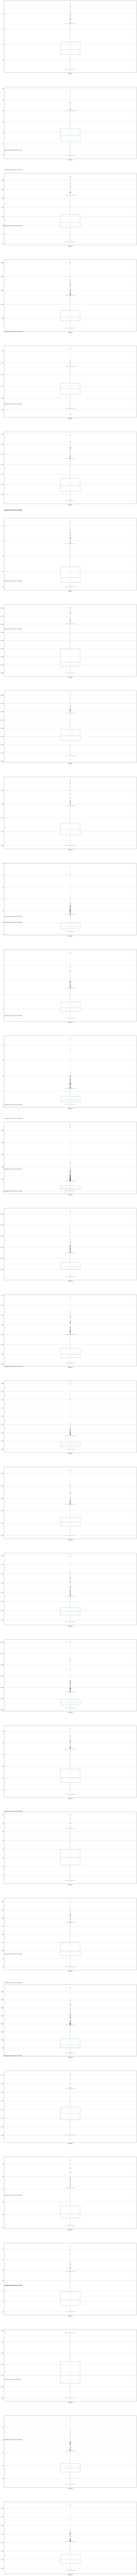

In [4]:
i = 1
width_in_inches = 25
height_in_inches = 500

plt.figure(figsize=(width_in_inches, height_in_inches))
for col in Columns:
    if (col != 'Diagnosis') and (col != 'ID'):
        #print(cancer_df.boxplot(column=col))
        plt.subplot(30, 1, i)
        plt.text(.5, .5, cancer_df.boxplot(column=col),
                 fontsize=8,)
        i = i + 1
    

For the exploration I separated the features into the following range categories:

Low Range (x<5):5,6,7,8,9,10,11,12,13,15,16,17,18,19,20,25,26,27,28,29,30
Mid Range(5<x<50) Features:1,2,21,22
High Range:(50<x<500) Features:3,14,23
Very High Range (x>500+) Features: 4,24

Spread was a bit more arbitrary, but I looked for proportional differences in the IQR and whiskers.

low spread:11,12,13,14,15,16,17,20,24,
high spread:1,2,3,4,5,6,7,8,9,10,18,19,20,21,22,23,25,26,27,28,29,30

From these brief overview's I suggest that categories with high range and high spread will be the most predictive. This includes Features 3 and 23.

Now let's get a better idea of the separation for the diagnosis based on each feature by creating boxplots for each feature.

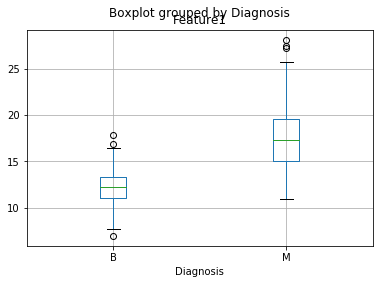

In [5]:
cancer_df.boxplot(by='Diagnosis', column='Feature1')

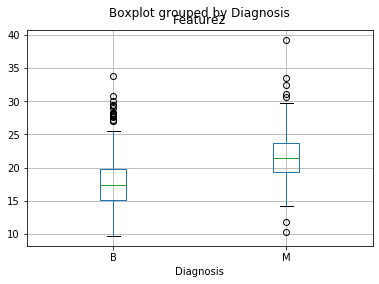

In [6]:
cancer_df.boxplot(by='Diagnosis', column='Feature2')

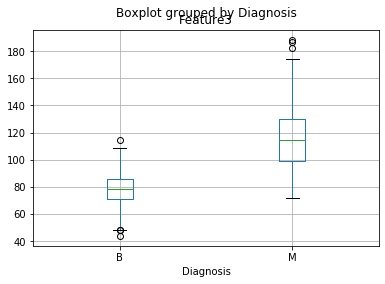

In [7]:
cancer_df.boxplot(by='Diagnosis', column='Feature3')

In [8]:
cancer_df.boxplot(by='Diagnosis', column='Feature4')

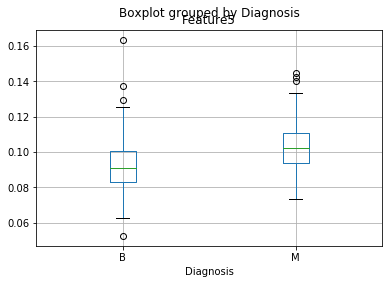

In [9]:
cancer_df.boxplot(by='Diagnosis', column='Feature5')

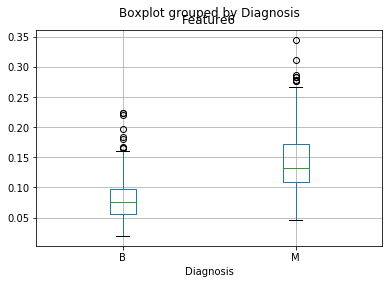

In [10]:
cancer_df.boxplot(by='Diagnosis', column='Feature6')

In [11]:
cancer_df.boxplot(by='Diagnosis', column='Feature7')

In [12]:
cancer_df.boxplot(by='Diagnosis', column='Feature8')

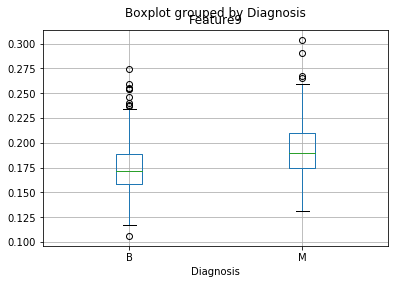

In [13]:
cancer_df.boxplot(by='Diagnosis', column='Feature9')

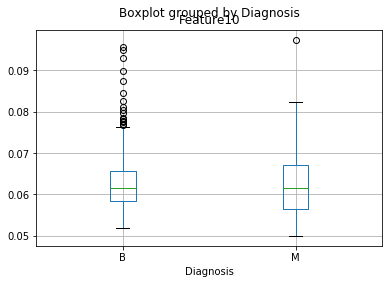

In [14]:
cancer_df.boxplot(by='Diagnosis', column='Feature10')

In [15]:
cancer_df.boxplot(by='Diagnosis', column='Feature11')

In [16]:
cancer_df.boxplot(by='Diagnosis', column='Feature12')

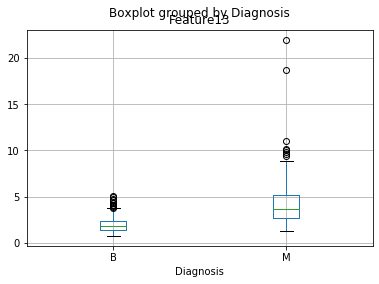

In [17]:
cancer_df.boxplot(by='Diagnosis', column='Feature13')

In [18]:
cancer_df.boxplot(by='Diagnosis', column='Feature14')

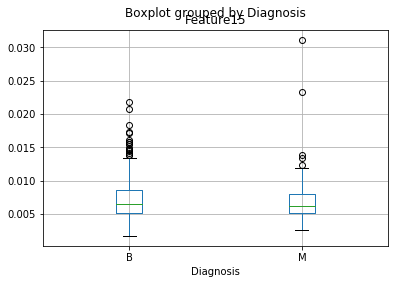

In [19]:
cancer_df.boxplot(by='Diagnosis', column='Feature15')

In [20]:
cancer_df.boxplot(by='Diagnosis', column='Feature16')

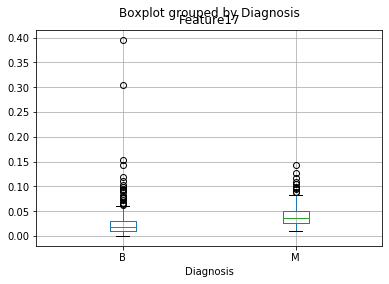

In [21]:
cancer_df.boxplot(by='Diagnosis', column='Feature17')

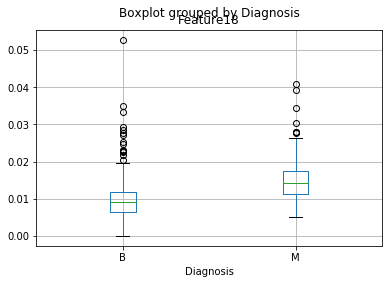

In [22]:
cancer_df.boxplot(by='Diagnosis', column='Feature18')

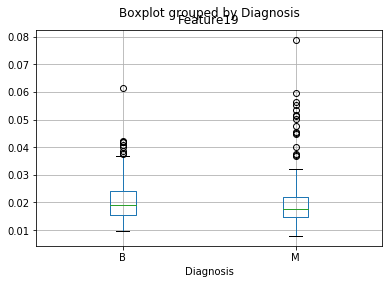

In [23]:
cancer_df.boxplot(by='Diagnosis', column='Feature19')

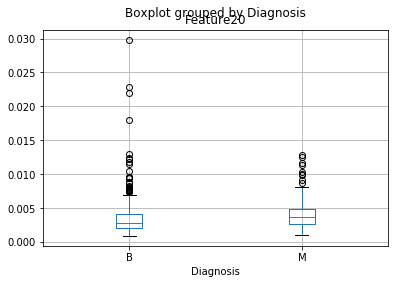

In [24]:
cancer_df.boxplot(by='Diagnosis', column='Feature20')

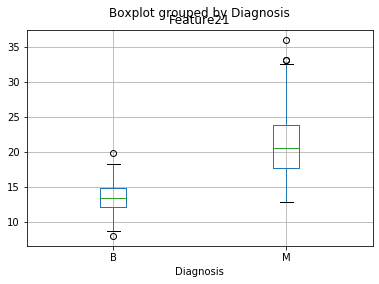

In [25]:
cancer_df.boxplot(by='Diagnosis', column='Feature21')

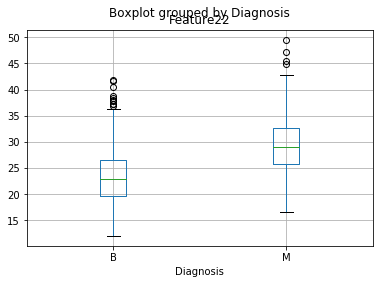

In [26]:
cancer_df.boxplot(by='Diagnosis', column='Feature22')

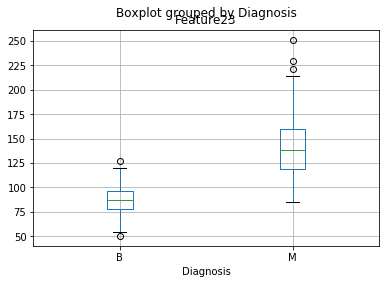

In [27]:
cancer_df.boxplot(by='Diagnosis', column='Feature23')

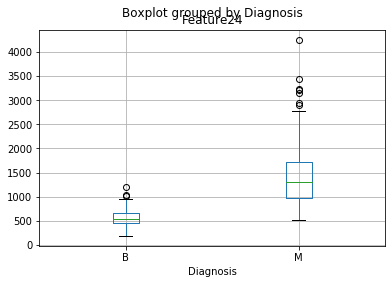

In [28]:
cancer_df.boxplot(by='Diagnosis', column='Feature24')

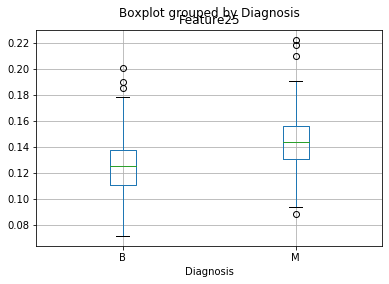

In [29]:
cancer_df.boxplot(by='Diagnosis', column='Feature25')

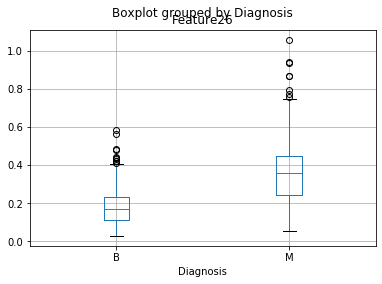

In [30]:
cancer_df.boxplot(by='Diagnosis', column='Feature26')

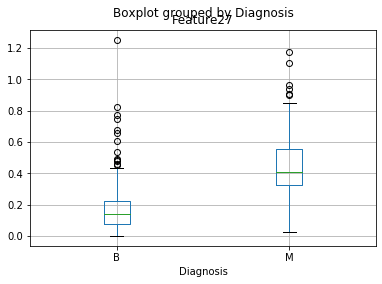

In [31]:
cancer_df.boxplot(by='Diagnosis', column='Feature27')

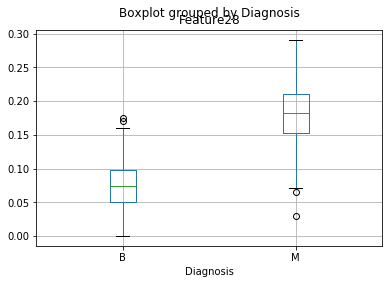

In [32]:
cancer_df.boxplot(by='Diagnosis', column='Feature28')

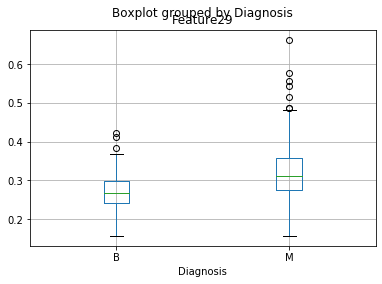

In [33]:
cancer_df.boxplot(by='Diagnosis', column='Feature29')

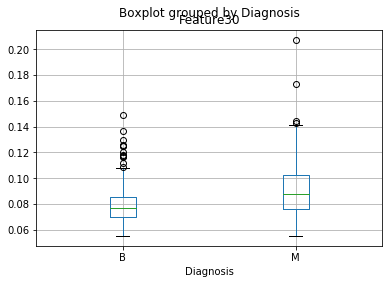

In [34]:
cancer_df.boxplot(by='Diagnosis', column='Feature30')

After Investigating the separation of each boxplot, I have determined Features 1,3,4,7,8,21,23,24, and 28 have the most relative separation. In the first graph section I suggested features 3 and 23 would be the most predictive, this is consistent with further analysis in separation. I suggest that separation is more important than range and spread, so the features that have larger separation (the ones I identified) will likely impact the model the most.

### Logistical Regression
Next, let's look at actually creating regression models using these features to see if the features we identified in EDA will actually be predictive or not; and overall see if we can create a model to accurately predict breast cancer classification based on these features.

Let’s first split our data into testing and training sets and tell the model to stratify based on the accepted diagnosis.

In [35]:
df_train, df_test = train_test_split(cancer_df, stratify=cancer_df["Diagnosis"])
print(cancer_df.shape[0], df_train.shape[0], df_test.shape[0])

569 426 143


In [36]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(df_train["Diagnosis"].astype("str"))
y_test = encoder.transform(df_test["Diagnosis"].astype("str"))

#### Null Model
Now let’s create a null model for the classification which we can use to compare our predictive models against.


In [37]:
zeros_train = np.zeros(df_train.shape)
zeros_test = np.zeros(df_test.shape)

null_lr = SGDClassifier(max_iter=10000, loss="log")
null_lr.fit(zeros_train, y_train)
pred_null_labels = null_lr.predict(zeros_test)
pred_prob = null_lr.predict_proba(zeros_test)

null_accuracy = accuracy_score(y_test, pred_null_labels)
null_loss = log_loss(y_test, pred_prob)
cm = confusion_matrix(y_test, pred_null_labels)

print("Accuracy:", null_accuracy)
print("Loss:", null_loss)
print("Labels:", encoder.classes_)
print("Confusion matrix:")
print(cm)

Accuracy: 0.6293706293706294
Loss: 0.6810583344648776
Labels: ['B' 'M']
Confusion matrix:
[[90  0]
 [53  0]]


The null model ends up guessing the most common result. In this case, that the diagnosis is benign. With this scheme, we can see there is an accuracy of ~63% which is not great.

#### Predictive Model
Let’s now move onto our predictive logistical regression model using the greedy algorithm to identify the most impactful features. 

First, let's import the methods for creating classification feature matrixes.

In [38]:
def create_feature_matrices(df_train, df_test, selected_columns, dummy_columns):
    """
    Creates feature matrices for the training and testing sets from the given dataframes.
    The feature matrices are built from the columns given in selected columns.
    """
    
    # keep track of numerical features
    numerical_trial_columns = []
    
    # keep track of dummy features for categorical variables
    categorical_trial_columns = []
    
    # build feature lists
    for col_name in selected_columns:
        if col_name in dummy_columns:
            categorical_trial_columns.extend(dummy_columns[col_name])
        else:
            numerical_trial_columns.append(col_name)

    # transform numerical features
    if len(numerical_trial_columns) > 0:
        X_train_numerical = df_train[numerical_trial_columns].astype("float64").values
        X_test_numerical = df_test[numerical_trial_columns].astype("float64").values
    
        #imputer = Imputer()
        #X_train_numerical = imputer.fit_transform(X_train_numerical)
        #X_test_numerical = imputer.transform(X_test_numerical)
    
        scaler = StandardScaler()
        X_train_numerical = scaler.fit_transform(X_train_numerical)
        X_test_numerical = scaler.transform(X_test_numerical)
    
    # select categorical features
    if len(categorical_trial_columns) > 0:
        X_train_categorical = df_train[categorical_trial_columns].astype("float64").values
        X_test_categorical = df_test[categorical_trial_columns].astype("float64").values
    
    # concatenate feature matrices
    if len(numerical_trial_columns) > 0 and len(categorical_trial_columns) > 0:
        X_train = np.hstack([X_train_numerical, X_train_categorical])
        X_test = np.hstack([X_test_numerical, X_test_categorical])
    elif len(numerical_trial_columns) > 0:
        X_train = X_train_numerical
        X_test = X_test_numerical
    else:
        X_train = X_train_categorical
        X_test = X_test_categorical
        
    return X_train, X_test

Let's now use the create feature matrixes method to create a feature matrix for each breast cancer feature and then create a list containing all features and sort the features by how much they each impact the model accuracy.

In [39]:
feature_columns = []
for i in range(1,31):
    feature_columns.append('Feature'+str(i))
    
print("Null Model Accuracy:", null_accuracy)

column_accuracies = []

for col_name in feature_columns:
    X_train, X_test = create_feature_matrices(df_train,
                                             df_test,
                                             [col_name],
                                             [])
    
    simple_lr = SGDClassifier(max_iter=10000, loss="log")
    simple_lr.fit(X_train, y_train)
    pred_labels = simple_lr.predict(X_test)
    pred_probs = simple_lr.predict_proba(X_test)
    simple_accuracy = accuracy_score(y_test, pred_labels)
    simple_loss = log_loss(y_test, pred_probs)
    print()
    print(col_name + " Accuracy:", simple_accuracy)
    print(col_name + " Loss:", simple_loss)
    column_accuracies.append((simple_accuracy, col_name))
    
column_accuracies.sort(key=lambda p: p[0], reverse=True)
sorted_columns = [col_name for _, col_name in column_accuracies]
print()
print("Sorted columns:" + str(sorted_columns))

Null Model Accuracy: 0.6293706293706294

Feature1 Accuracy: 0.8391608391608392
Feature1 Loss: 0.3381834119503617

Feature2 Accuracy: 0.7552447552447552
Feature2 Loss: 0.5659423097296729

Feature3 Accuracy: 0.8811188811188811
Feature3 Loss: 0.32772408572240536

Feature4 Accuracy: 0.8671328671328671
Feature4 Loss: 0.32953915240129134

Feature5 Accuracy: 0.6573426573426573
Feature5 Loss: 0.6103641768555323

Feature6 Accuracy: 0.7832167832167832
Feature6 Loss: 0.43771349054566644

Feature7 Accuracy: 0.8671328671328671
Feature7 Loss: 0.36616243898202616

Feature8 Accuracy: 0.9090909090909091
Feature8 Loss: 0.21713240474872406

Feature9 Accuracy: 0.6573426573426573
Feature9 Loss: 0.6735331237402422

Feature10 Accuracy: 0.6223776223776224
Feature10 Loss: 0.7891832826117949

Feature11 Accuracy: 0.8321678321678322
Feature11 Loss: 0.40452083495171715

Feature12 Accuracy: 0.4755244755244755
Feature12 Loss: 0.924714320464113

Feature13 Accuracy: 0.8251748251748252
Feature13 Loss: 0.386507931799239

Using this now sorted list, lets perform a greedy algorithm on the features to see which features the greedy algorithm identifies as important. For each feature which increases the model accuracy, we will build our regressor on.

In [40]:
base_model_columns = []
base_loss = null_loss
base_accuracy = null_accuracy

print("Base Model Accuracy:", base_accuracy)
print("Base Model Loss:", base_loss)
print()

for col_name in sorted_columns:
    # track all column names
    trial_columns = base_model_columns[:]
    trial_columns.append(col_name)

    X_train, X_test = create_feature_matrices(df_train,
                                             df_test,
                                             trial_columns,
                                             [])
    
    trial_lr = SGDClassifier(max_iter=50000, loss="log", penalty="l2")
    trial_lr.fit(X_train, y_train)
    pred_labels = trial_lr.predict(X_test)
    pred_prob = trial_lr.predict_proba(X_test)
    trial_accuracy = accuracy_score(y_test, pred_labels)
    trial_loss = log_loss(y_test, pred_prob)
    print()
    print(str(trial_columns) + " Model Accuracy:", trial_accuracy)
    print(str(trial_columns) + " Model Loss:", trial_loss)

    if trial_accuracy > base_accuracy:
        print("Updating base model")
        base_loss = trial_loss
        base_model_columns = trial_columns
        base_accuracy = trial_accuracy
    print()
    print("Base Model Loss:", base_loss)
    print("Base Model Accuracy:", base_accuracy)
    print()
    
print("Our chosen columns are: " + str(base_model_columns))

Base Model Accuracy: 0.6293706293706294
Base Model Loss: 0.6810583344648776


['Feature28'] Model Accuracy: 0.9370629370629371
['Feature28'] Model Loss: 0.19298826563786525
Updating base model

Base Model Loss: 0.19298826563786525
Base Model Accuracy: 0.9370629370629371


['Feature28', 'Feature8'] Model Accuracy: 0.9440559440559441
['Feature28', 'Feature8'] Model Loss: 0.1771990566060192
Updating base model

Base Model Loss: 0.1771990566060192
Base Model Accuracy: 0.9440559440559441


['Feature28', 'Feature8', 'Feature23'] Model Accuracy: 0.9300699300699301
['Feature28', 'Feature8', 'Feature23'] Model Loss: 0.17579363336960832

Base Model Loss: 0.1771990566060192
Base Model Accuracy: 0.9440559440559441


['Feature28', 'Feature8', 'Feature14'] Model Accuracy: 0.9370629370629371
['Feature28', 'Feature8', 'Feature14'] Model Loss: 0.11412380660318945

Base Model Loss: 0.1771990566060192
Base Model Accuracy: 0.9440559440559441


['Feature28', 'Feature8', 'Feature24'] Model Accuracy: 0.92307

Originally, I suggested features 3 and 23 were going to be most predictive, with also features 1,4,7,8,21, and 24 being also quite predictive. What's interesting is that none of these features are present within our greedy model which contains features 28,8,11,2,22, and 19.

Let's now see how the model performs on the testing data set, again using our logistical regression methodology.

In [41]:
X_train, X_test = create_feature_matrices(df_train,
                                          df_test,
                                          base_model_columns,
                                          [])
    
lr = SGDClassifier(max_iter=10000, loss="log")
lr.fit(X_train, y_train)
pred_labels = lr.predict(X_test)
trial_accuracy = accuracy_score(y_test, pred_labels)
cm = confusion_matrix(y_test, pred_labels)
print()
print("Model Accuracy:", trial_accuracy)
print("Labels:", encoder.classes_)
print("Confusion matrix:")
print(cm)


Model Accuracy: 0.972027972027972
Labels: ['B' 'M']
Confusion matrix:
[[88  2]
 [ 2 51]]


Text(0, 0.5, 'True Positive Rate')

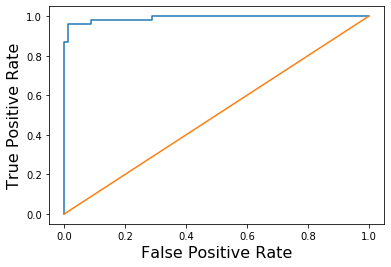

In [42]:
from sklearn.metrics import roc_curve

pred_proba = lr.predict_proba(X_test)

# turn multiclass problem into binary problem
pred_proba_1 = 1.0 - pred_proba[:, 0]
y_test_1 = [0 if y == 0 else 1 for y in y_test]

fpr, tpr, _ = roc_curve(y_test_1, pred_proba_1)

plt.plot(fpr, tpr)
plt.plot([0.0, 1.0], [0.0, 1.0])
plt.xlabel("False Positive Rate", fontsize=16)
plt.ylabel("True Positive Rate", fontsize=16)

The greedy model definitely performs a lot better than the null model with an accuracy of 97%. I'd still say though with real live patients, 97% still could be better. Let's now create a model using all the features to see if it outperforms the greedy model.

In [43]:
X_train, X_test = create_feature_matrices(df_train,
                                          df_test,
                                          feature_columns,
                                          [])
    
lr = SGDClassifier(max_iter=10000, loss="log")
lr.fit(X_train, y_train)
pred_labels = lr.predict(X_test)
trial_accuracy = accuracy_score(y_test, pred_labels)
cm = confusion_matrix(y_test, pred_labels)
print()
print("Model Accuracy:", trial_accuracy)
print("Labels:", encoder.classes_)
print("Confusion matrix:")
print(cm)


Model Accuracy: 0.972027972027972
Labels: ['B' 'M']
Confusion matrix:
[[88  2]
 [ 2 51]]


Text(0, 0.5, 'True Positive Rate')

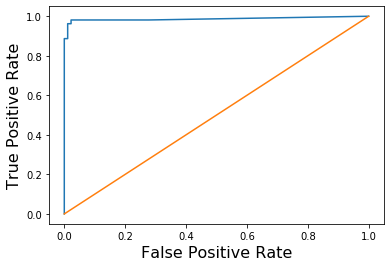

In [44]:
pred_proba = lr.predict_proba(X_test)

# turn multiclass problem into binary problem
pred_proba_1 = 1.0 - pred_proba[:, 0]
y_test_1 = [0 if y == 0 else 1 for y in y_test]

fpr, tpr, _ = roc_curve(y_test_1, pred_proba_1)

plt.plot(fpr, tpr)
plt.plot([0.0, 1.0], [0.0, 1.0])
plt.xlabel("False Positive Rate", fontsize=16)
plt.ylabel("True Positive Rate", fontsize=16)

As it turns out, the all features model is just as effective as the model produced by the greedy algorithm, having identical accuracy and confusion matrixes.

### Model evaluation and reflection
The null model had an accuracy of 68%, undefined precision, and recall of 0. The greedy algorithm had an accuracy of 97%, .96 precision and .96 recall. And finally, the all model had an accuracy of also 97%, .96 precision and .96 recall.

the null model is most prone to false negatives while the other models are equally as likely to false positives and false negatives. In our scenario with breast cancer the most important factor is to reduce the number of false negatives because you don't want to misdiagnose someone as not having cancer when they actually do; you would much rather have false positives and be extra cautious when diagnosing cancer which can potentially be life threatening.

As expected, the null model has the worst predictive power with both of the feature models being better. What's interesting is that both the all model and greedy model had the same predictive power; this may be strange coincidence of the random train/test split, but at the bare minimum it validates that all the features provide some valuable information.
